## import Modules

In [1]:
import os
import cv2
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read images

In [2]:
lick_folder = 'lick'
void_folder = 'void'

lick_image_list = os.listdir(lick_folder)
void_image_list = os.listdir(void_folder)
lick_nsample = len(lick_image_list)
void_nsample = len(void_image_list)
# attention: positive and negative sample number balance!

n_total_sample = lick_nsample + void_nsample
X = np.empty(shape = (n_total_sample, 300, 300, 3)) # resize image into 300x300
count = 0
for image_filename in lick_image_list:
	image_fullname = os.path.join(lick_folder,image_filename)
	img = cv2.cvtColor(cv2.imread(image_fullname), cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
	X[count,:,:,:]=img
	count += 1

for image_filename in void_image_list:
	image_fullname = os.path.join(void_folder,image_filename)
	img = cv2.cvtColor(cv2.imread(image_fullname), cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
	X[count,:,:,:]=img
	count += 1

y = np.concatenate((np.ones(shape = (lick_nsample, 1)),np.zeros(shape = (void_nsample, 1))))

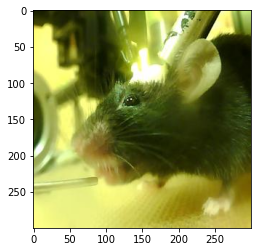

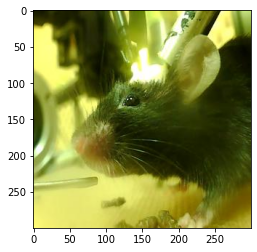

In [30]:
idx = random.randint(0,lick_nsample)
image_fullname = os.path.join(lick_folder,lick_image_list[idx])
img_lick_example = cv2.cvtColor(cv2.imread(image_fullname), cv2.COLOR_BGR2RGB)
plt.imshow(img_lick_example)
plt.show()

idx = random.randint(0,void_nsample)
image_fullname = os.path.join(void_folder,void_image_list[idx])
img_void_example = cv2.cvtColor(cv2.imread(image_fullname), cv2.COLOR_BGR2RGB)
plt.imshow(img_void_example)

## Train Test set splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

## Conv Model

In [23]:
def LickModel(input_shape):
    """
    Implementation of the LickModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]    

    Returns:
    model -- a Model() instance
    """
    
    # input place holder
    X_input = Input(input_shape)     
    # zero-padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # CONV -- BN -- RELU
    X = Conv2D(32, (9,9), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)    
    # MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool')(X)
    
    # CONV -- BN -- RELU
    X = Conv2D(64, (7,7), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)    
    # MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool1')(X)
    
        
    # CONV -- BN -- RELU
    X = Conv2D(64, (5,5), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)    
    # MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool2')(X)
    
    # CONV -- BN -- RELU
    X = Conv2D(128, (3,3), strides = (1, 1), name = 'conv3',kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)    
    # MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool3')(X)
    
    '''# CONV -- BN -- RELU
    X = Conv2D(128, (3,3), strides = (1, 1), name = 'conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)    
    # MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool4')(X)
    '''
    # FLATEN and FULLYCONNECTED
    X = Flatten()(X)
    X = Dropout(0.2)(X)
    X = Dense(1, activation='sigmoid', name = 'fc')(X)
    
    # CREATE MODEL
    model = Model(inputs=X_input, outputs=X, name='LickModel')    
    return model

## Fit and evaluate the model

In [24]:
lickModel = LickModel(X_train.shape[1:])
lickModel.summary()

Model: "LickModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 306, 306, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 298, 298, 32)      7808      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 298, 298, 32)      128       
_________________________________________________________________
activation_8 (Activation)    (None, 298, 298, 32)      0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 149, 149, 32)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 143, 143, 64)      10

In [25]:
# learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07
lickModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Early stopping to prevent overfitting

In [26]:
# Or Early stopping to prevent overfitting
callback = EarlyStopping(monitor='loss', patience=3)
lickModel.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), callbacks=[callback], epochs = 30, batch_size = 16, verbose = 2)

Epoch 1/30
16/16 - 2s - loss: 21.6564 - accuracy: 0.5586 - val_loss: 23.1654 - val_accuracy: 0.5581
Epoch 2/30
16/16 - 1s - loss: 16.4529 - accuracy: 0.8477 - val_loss: 20.6538 - val_accuracy: 0.5581
Epoch 3/30
16/16 - 1s - loss: 11.9406 - accuracy: 0.9453 - val_loss: 12.3011 - val_accuracy: 0.5581
Epoch 4/30
16/16 - 1s - loss: 8.1176 - accuracy: 0.9180 - val_loss: 8.2649 - val_accuracy: 0.5581
Epoch 5/30
16/16 - 1s - loss: 5.2417 - accuracy: 0.9102 - val_loss: 4.2316 - val_accuracy: 0.8488
Epoch 6/30
16/16 - 1s - loss: 3.1500 - accuracy: 0.9570 - val_loss: 3.5051 - val_accuracy: 0.4419
Epoch 7/30
16/16 - 1s - loss: 2.1758 - accuracy: 0.9336 - val_loss: 1.7872 - val_accuracy: 0.9884
Epoch 8/30
16/16 - 1s - loss: 1.4799 - accuracy: 0.9258 - val_loss: 1.5786 - val_accuracy: 0.8023
Epoch 9/30
16/16 - 1s - loss: 1.5038 - accuracy: 0.8867 - val_loss: 1.4701 - val_accuracy: 0.9535
Epoch 10/30
16/16 - 1s - loss: 1.4059 - accuracy: 0.9258 - val_loss: 1.4847 - val_accuracy: 0.8837
Epoch 11/30
1

## Prediction and evaluation

In [27]:
preds = lickModel.evaluate(x = X_test, y = y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 [==============================] - 0s 47ms/step - loss: 0.9451 - accuracy: 0.9767
Loss = 0.945056676864624
Test Accuracy = 0.9767441749572754


In [ ]:
y_pred = lickModel.predict(X_test)
y_pred_class = y_pred>0.5
classification_report(y_test, y_pred_class)

AUC: 0.9956140350877193


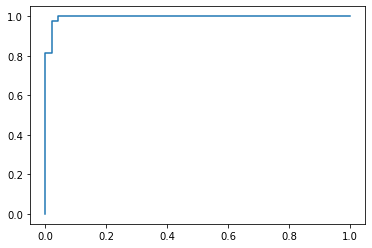

In [29]:
y_pred_class = y_pred>0.5
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
print('AUC:',auc(fpr, tpr))